# Imports

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray

Saving kaggle.json to kaggle.json
100% 1.51G/1.51G [00:28<00:00, 123MB/s]
100% 1.51G/1.51G [00:28<00:00, 57.6MB/s]


In [ ]:
# !unzip chest-xray-pneumonia.zip
!unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray204.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray205.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray206.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray207.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray208.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray209.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray21.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray210.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray211.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray212.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray213.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORMAL/normal-xray214.jpeg  
  inflating: data/chest_xray/chest_xray/train/NORM

In [ ]:
import os
imagefiles=[]
labels=[]
for folder in os.listdir('./data/chest_xray/chest_xray/train'):
  path=os.path.join('./data/chest_xray/chest_xray/train',folder)
  for images in os.listdir(path):
    imagefiles.append(os.path.join(path,images))
    labels.append(folder)
testimages=[]
testlabel=[]
for folder in os.listdir('./data/chest_xray/chest_xray/test'):
  path=os.path.join('./data/chest_xray/chest_xray/test',folder)
  for images in os.listdir(path):
    testimages.append(os.path.join(path,images))
    testlabel.append(folder)
enc={}
for i,label in enumerate(os.listdir('./data/chest_xray/chest_xray/train')):
  enc[label]=i

In [ ]:
# os.listdir('./data/chest_xray/chest_xray/train')
# os.remove('./data/chest_xray/chest_xray/test/.DS_Store')
# os.remove('./data/chest_xray/chest_xray/train/.DS_Store')
# os.remove('./data/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store')
# os.remove('./data/chest_xray/chest_xray/train/NORMAL/.DS_Store')
# os.remove('./data/chest_xray/chest_xray/train/COVID/.DS_Store')

FileNotFoundError: ignored

In [ ]:
# os.remove('/content/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store')

# VAE: Load Data, prepare methods

In [ ]:
class Data(Dataset):
  def __init__(self,imagefiles,labels,testimages,testlabel,mode,enc=None,transform=None):
    self.imagefiles=imagefiles
    self.labels=labels
    self.testimages=testimages
    self.testlabel=testlabel
    self.mode=mode
    self.transform=transform
    self.enc=enc
  def __getitem__(self,idx):
    if self.mode=='train':
      image=Image.open(self.imagefiles[idx])
      image=np.asarray(image)
      #image = np.fromstring(image.tobytes(), dtype=np.uint8)
      #image = image.reshape((image.size[1], image.size[0], 1)) 
      image=torch.from_numpy(image)
      label=self.labels[idx]
      if self.transform:
        image=self.transform(image)
      return image,enc[label]
    if self.mode=='test':
      image=Image.open(self.testimages[idx])
      image=np.asarray(image)
     # image = np.fromstring(image.tobytes(), dtype=np.uint8)
      #image = image.reshape((image.size[1], image.size[0], 1)) 
      image=torch.from_numpy(image)
      label=self.testlabel[idx]
      if self.transform:
        image=self.transform(image)
      return image,enc[label]
  def __len__(self):
    if self.mode=='train':
      return len(self.imagefiles)
    if self.mode=='test':
      return len(self.testimages)

In [ ]:
transform=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize((100,100)),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
])

In [ ]:
mode1='train'
trainset=Data(imagefiles,labels,testimages,testlabel,mode1,enc,transform)

In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=True)


In [ ]:
# for img,label in trainloader:
#   print(img.shape)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  app.launch_new_instance()


torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5,

KeyboardInterrupt: ignored

torch.Size([5])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  app.launch_new_instance()


torch.Size([5, 1, 100, 100])

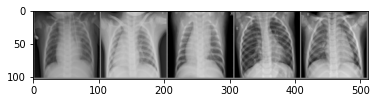

In [ ]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
import matplotlib.pyplot as plt
img,lab=next(iter(trainloader))
x=torchvision.utils.make_grid(img)
imshow(x)
print(lab.shape)
img.shape

In [ ]:
mode2='test'
testset=Data(imagefiles,labels,testimages,testlabel,mode2,enc,transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=5,shuffle=False)

In [ ]:
# for img,label in testloader:
#   print(img.shape)

torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])
torch.Size([5, 1, 100, 100])


TypeError: ignored

Grayscale reshaped

torch.Size([5])


torch.Size([5, 1, 100, 100])

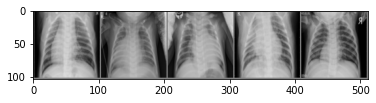

In [ ]:
import torchvision
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
import matplotlib.pyplot as plt
img,lab=next(iter(testloader))
x=torchvision.utils.make_grid(img)
imshow(x)
print(lab.shape)
img.shape

# VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        #3*128*128=49152
        self.fc1 = nn.Linear(10000, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 10000)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 10000))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Parameters & Run Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#encoder = Encoder(10000, 256, 20)
#
    # decoder
#decoder = Decoder(20, 256, 10000)

    # vae
model = VAE()

    # optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:
best_test_loss = float('inf')
patience_counter=0
for epochs in range(0,31):
  train_loss=0
  test_loss = 0
  print('Started accessing trainloader')
  for img,lab in trainloader:
    img=img.view(-1,10000)
    img=F.softmax(img)
    #img=img.to(device)
    optimizer.zero_grad()
# forward pass
    img_sample, z_mu, z_var = model(img)
   # print(f'before softmax : {img_sample}')
    #img_sample=F.softmax(img_sample)
   # print(f'after softmax : {img_sample}')
    recon_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
# kl divergence loss
    kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
# total loss
    loss = recon_loss + kl_loss
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  else:
    with torch.no_grad():
      print('accessing test loader')
      for img,lab in testloader:
        # reshape the data
        img = img.view(-1, 10000)
        img=F.softmax(img)
       # img=img.to(device)
        # forward pass
        img_sample, z_mu, z_var = model(img)
        #img_sample=F.softmax(img_sample)
        # reconstruction loss
        recon_loss = F.binary_cross_entropy(img_sample, img, size_average=False)
        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        # total loss
        loss = recon_loss + kl_loss
        test_loss += loss.item()

  train_loss /= len(trainloader)
  test_loss /= len(testloader)
  print(f'Epoch {epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
  if best_test_loss > test_loss:
    best_test_loss = test_loss
    patience_counter = 1
  else:
    patience_counter += 1
  if patience_counter > 3:
    break

Started accessing trainloader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


accessing test loader


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0, Train Loss: 208.79, Test Loss: 54.38
Started accessing trainloader
accessing test loader
Epoch 1, Train Loss: 53.74, Test Loss: 53.38
Started accessing trainloader
accessing test loader
Epoch 2, Train Loss: 53.06, Test Loss: 52.48
Started accessing trainloader
accessing test loader
Epoch 3, Train Loss: 52.31, Test Loss: 51.94
Started accessing trainloader
accessing test loader
Epoch 4, Train Loss: 51.57, Test Loss: 51.20
Started accessing trainloader
accessing test loader
Epoch 5, Train Loss: 51.10, Test Loss: 50.95
Started accessing trainloader
accessing test loader
Epoch 6, Train Loss: 50.92, Test Loss: 50.85
Started accessing trainloader
accessing test loader
Epoch 7, Train Loss: 50.87, Test Loss: 50.84
Started accessing trainloader
accessing test loader
Epoch 8, Train Loss: 50.89, Test Loss: 50.83
Started accessing trainloader
accessing test loader
Epoch 9, Train Loss: 50.95, Test Loss: 50.95
Started accessing trainloader
accessing test loader
Epoch 10, Train Loss: 51.14, 

# Save to drive

In [ ]:
image_dir = '/content/gdrive/My Drive/Deep Learning HW'

torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size([1, 20])
torch.Size([100, 100])
torch.Size(

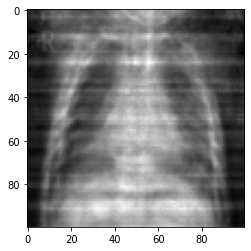

In [ ]:
for img_num in range(1,51):
    z = torch.randn(1, 20)
    # run only the decoder
    reconstructed_img = model.decode(z)
    img = reconstructed_img.view(100, 100).data
    print(z.shape)
    print(img.shape)
    plt.imshow(img,cmap='gray')
    name_img = img_num
    plt.savefig("{}/VAE_{}.jpg".format(image_dir, name_img))
        # plt.savefig(f"{image_dir}/VAE{}.jpg".format(name_img))

# ResNet34 Goes Here